Notes:
* dask GroupBy tuning https://youtu.be/QY0zFsaO2j8

In [1]:
import dask.dataframe as dd
import pandas as pd
import dask
import os

from distributed import Client, progress, wait

dask.config.set(temporary_directory=os.getcwd())
#dask.config.set(temporary_directory='/media/ian/data/mot_pandas2_polars_dask/data')

In [2]:
os.chdir("../..")

client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 31.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39503,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.29 GiB
Comm: tcp://127.0.0.1:34381,Total threads: 1
Dashboard: http://127.0.0.1:32853/status,Memory: 1.96 GiB
Nanny: tcp://127.0.0.1:34031,


In [3]:
# 2m15s Giles
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result.parquet",
        dtype_backend="pyarrow",
        columns=[
            "vehicle_id",
            "make",
            "model",
            "fuel_type",
            "cylinder_capacity",
            "first_use_date",
            "test_date",
            "test_mileage",
        ],
        filters=[
            ("make", "in", ["VOLVO", "VOLKSWAGEN"]),
            ("model", "in", ["V50", "PASSAT"]),
        ],
    )
    #.set_index('vehicle_id', npartitions=96, shuffle='tasks')
    #.repartition(npartitions=96)
    #.partitions[:3]
    .groupby("vehicle_id").agg(
        {
            "make": "last",
            "model": "last",
            "fuel_type": "last",
            "cylinder_capacity": "last",
            "first_use_date": "last",
            "test_date": "max",
            "test_mileage": "max",
        },
        shuffle='p2p',
        split_every=32,
        split_out=16,
    )
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [4]:
def vehicle_grouper(df, groupby_sort=True, agg_shuffle=None):
    """Get summary data for each vehicle"""
    vehicle_df = df.groupby(
        "vehicle_id",
        sort=groupby_sort,  # True, False
    ).agg(
        {
            "make": "last",
            "model": "last",
            "fuel_type": "last",
            "cylinder_capacity": "last",
            "first_use_date": "last",
            "test_date": "max",
            "test_mileage": "max",
        },
        shuffle=agg_shuffle,  # None, 'disk', 'tasks', 'p2p'
    )
    return vehicle_df


def add_lifetime(df):
    """Get vehicle lifespan (vehicle may or may not still be in service)"""
    df["lifetime"] = (
        dd.to_timedelta((df["test_date"] - df["first_use_date"]))
        .astype('timedelta64[ns]')
        .dt.days / 365
    )
    return df

In [5]:
# 30m16s Giles, 18min Ian
# 2023-11 3m9s
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result.parquet",
        dtype_backend='pyarrow',
        filters=[("make", "in", ["VOLVO", "VOLKSWAGEN"])],
        columns=['vehicle_id', 'make', 'model', 'fuel_type', 'cylinder_capacity', 'first_use_date', 'test_date', 'test_mileage'],
    )
    .set_index('vehicle_id')
    .query(
        'make in ["VOLVO", "VOLKSWAGEN"] & model in ["V50", "PASSAT"]'
    )
    .dropna()
    .pipe(vehicle_grouper)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [6]:
# 29m18s Giles, 34min to 854/854 aggregate-chunks and 120/123 agg-combines,then it seemlingly got stuck
# 2023-11 7m20s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet", dtype_backend="pyarrow")
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [7]:
# 6m55s Giles
# 2023-11 2m48s
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle=None)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [8]:
# 11m02s Giles
# 2023-11 2m26s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet", dtype_backend="pyarrow")
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [9]:
# 2m19s Giles, Ian 3min
# 2023-11 50s
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [10]:
# 2m15s Giles
# 2023-11 42s
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
        columns=[
            "make",
            "model",
            "fuel_type",
            "cylinder_capacity",
            "first_use_date",
            "test_date",
            "test_mileage",
        ],
        filters=[
            ("make", "in", ["VOLVO", "VOLKSWAGEN", "ROVER"]),
            ("model", "in", ["V50", "PASSAT", "200", "200 VI"]),
        ],
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=False, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [11]:
# Lifetime
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [12]:
vehicle_summary_ddf.head()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime
vehicle_id,,,,,,,,
87332,VOLKSWAGEN,PASSAT,DI,1968,2006-06-21 00:00:00,2015-12-02 00:00:00,206092,9.454795
236594,VOLKSWAGEN,PASSAT,DI,1896,2001-11-26 00:00:00,2012-01-14 00:00:00,194532,10.139726
1650930,VOLKSWAGEN,PASSAT,PE,1781,1990-04-13 00:00:00,2007-02-09 00:00:00,97523,16.838356
1989616,VOLKSWAGEN,PASSAT,DI,1896,2005-05-06 00:00:00,2019-09-10 00:00:00,133248,14.356164
2187358,VOLKSWAGEN,PASSAT,DI,1896,1997-03-01 00:00:00,2014-01-27 00:00:00,121038,16.920548


In [13]:
vehicle_summary_pdf = vehicle_summary_ddf.compute().sort_index()
vehicle_summary_pdf["test_date"] = pd.to_datetime(vehicle_summary_pdf["test_date"])
vehicle_summary_pdf["first_use_date"] = pd.to_datetime(
    vehicle_summary_pdf["first_use_date"]
)
vehicle_summary_pdf["surviving"] = vehicle_summary_pdf["test_date"] >= pd.Timestamp(
    "2022-01-01"
)
vehicle_summary_pdf["surviving_colour"] = vehicle_summary_pdf.surviving.map(
    {True: "blue", False: "red"}
)
vehicle_summary_pdf["fuel_colour"] = vehicle_summary_pdf.fuel_type.map(
    {"DI": "black", "PE": "blue", "HY": "green"}
)
vehicle_summary_pdf

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
1658,VOLKSWAGEN,PASSAT,PE,1595,1998-01-20,2008-01-04,124582,9.961644,False,red,blue
5292,VOLKSWAGEN,PASSAT,PE,1781,1998-01-07,2009-09-02,100890,11.660274,False,red,blue
6660,VOLKSWAGEN,PASSAT,DI,1968,2009-03-23,2022-02-14,53477,12.906849,True,blue,black
8926,VOLKSWAGEN,PASSAT,PE,1781,1998-03-12,2013-11-27,174062,15.723288,False,red,blue
11344,VOLKSWAGEN,PASSAT,DI,1896,2001-09-05,2016-05-21,190847,14.717808,False,red,black
...,...,...,...,...,...,...,...,...,...,...,...
1499988570,VOLKSWAGEN,PASSAT,PE,1800,1999-11-16,2014-10-20,101031,14.936986,False,red,blue
1499994122,VOLKSWAGEN,PASSAT,PE,3189,2006-09-28,2015-07-13,24498,8.794521,False,red,blue
1499995114,VOLKSWAGEN,PASSAT,DI,1896,2003-03-07,2016-03-15,180682,13.032877,False,red,black


In [14]:
vehicle_summary_pdf.groupby(["make", "surviving"])["model"].count()

make        surviving
ROVER       False          7718
            True            187
VOLKSWAGEN  False        343535
            True         206727
VOLVO       False         17511
            True          35424
Name: model, dtype: int64

In [15]:
vehicle_summary_pdf.model.value_counts()

model
PASSAT    550260
V50        52936
200         7293
200 VI       613
Name: count, dtype: int64[pyarrow]

In [16]:
vehicle_summary_pdf.fuel_type.value_counts()

fuel_type
DI    477552
PE    129847
HY      3430
LP       237
EL        26
GB         4
ST         2
OT         2
CN         1
ED         1
Name: count, dtype: int64[pyarrow]

In [17]:
vehicle_summary_pdf.query('model == "200" & test_mileage == 205404')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
1238787680,ROVER,200,PE,1796,1997-09-08,2016-08-16,205404,18.950685,False,red,blue


In [18]:
vehicle_summary_pdf.query('model == "V50" & test_mileage == 171443')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
815632906,VOLVO,V50,DI,1560,2007-12-20,2022-05-03,171443,14.378082,True,blue,black
1042513740,VOLVO,V50,DI,1997,2005-03-10,2022-05-12,171443,17.183562,True,blue,black


In [19]:
vehicle_summary_pdf.query('model == "PASSAT" & test_mileage == 142191')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
633992338,VOLKSWAGEN,PASSAT,DI,1968,2006-05-03,2017-05-16,142191,11.043836,False,red,black
716489940,VOLKSWAGEN,PASSAT,DI,1896,1997-05-22,2006-10-10,142191,9.391781,False,red,black
1162861794,VOLKSWAGEN,PASSAT,PE,1781,2002-03-25,2014-10-29,142191,12.605479,False,red,blue
1354367214,VOLKSWAGEN,PASSAT,PE,1798,1999-01-07,2022-02-08,142191,23.104110,True,blue,blue


In [20]:
vehicle_summary_pdf.query("vehicle_id in [1042513740, 1238787680, 1354367214]")

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
1042513740,VOLVO,V50,DI,1997,2005-03-10,2022-05-12,171443,17.183562,True,blue,black
1238787680,ROVER,200,PE,1796,1997-09-08,2016-08-16,205404,18.950685,False,red,blue
1354367214,VOLKSWAGEN,PASSAT,PE,1798,1999-01-07,2022-02-08,142191,23.104110,True,blue,blue


In [21]:
v50s_df = (
    vehicle_summary_pdf.assign(year=vehicle_summary_pdf.first_use_date.dt.year).query(
        'model == "V50" & fuel_type == "DI" & cylinder_capacity == 1997'
    )
    # .query('1997 <= year <= 2001')
)

v50s_df.groupby("year").count()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
year,,,,,,,,,,,
2004,173,173,173,173,173,173,173,173,173,173,173
2005,401,401,401,401,401,401,401,401,401,401,401
2006,364,364,364,364,364,364,364,364,364,364,364
2007,1150,1150,1150,1150,1150,1150,1150,1150,1150,1150,1150
2008,1687,1687,1687,1687,1687,1687,1687,1687,1687,1687,1687
2009,1590,1590,1590,1590,1590,1590,1590,1590,1590,1590,1590
2010,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580
2011,773,773,773,773,773,773,773,773,773,773,773
2012,316,316,316,316,316,316,316,316,316,316,316


In [22]:
passats_df = (
    vehicle_summary_pdf.assign(year=vehicle_summary_pdf.first_use_date.dt.year)
    .query('model == "PASSAT" & fuel_type == "PE" & cylinder_capacity == 1798')
    .query("1997 <= year <= 2001")
)

passats_df  # .groupby('year').count()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour,year
vehicle_id,,,,,,,,,,,,
268902,VOLKSWAGEN,PASSAT,PE,1798,1999-10-15,2010-05-20,94214,10.602740,False,red,blue,1999
544746,VOLKSWAGEN,PASSAT,PE,1798,2000-09-30,2019-08-07,155385,18.863014,False,red,blue,2000
1702856,VOLKSWAGEN,PASSAT,PE,1798,1998-12-04,2015-02-25,159444,16.238356,False,red,blue,1998
2183688,VOLKSWAGEN,PASSAT,PE,1798,1999-09-08,2021-07-08,130949,21.846575,False,red,blue,1999
2184752,VOLKSWAGEN,PASSAT,PE,1798,1999-01-20,2014-01-20,155222,15.010959,False,red,blue,1999
...,...,...,...,...,...,...,...,...,...,...,...,...
1498564910,VOLKSWAGEN,PASSAT,PE,1798,2000-11-08,2016-12-08,98574,16.093151,False,red,blue,2000
1498854052,VOLKSWAGEN,PASSAT,PE,1798,2000-04-18,2016-01-20,135325,15.767123,False,red,blue,2000
1499320290,VOLKSWAGEN,PASSAT,PE,1798,2000-04-07,2011-01-20,125873,10.794521,False,red,blue,2000


In [23]:
#rovers_df = vehicle_summary_pdf.query(
#    'model in ["200", "200 VI"] & cylinder_capacity == 1796'
#)#
#
#rovers_df

In [24]:
#ax = rovers_df.dropna().plot.scatter(
#    figsize=(12, 6),
#    x="lifetime",
#    y="test_mileage",
#    marker=".",
#    alpha=0.5,
#    # s=0.5,
#    c="surviving_colour",
#)
#ax.set_xlim(5, 26)
#ax.set_ylim(0, 250000)

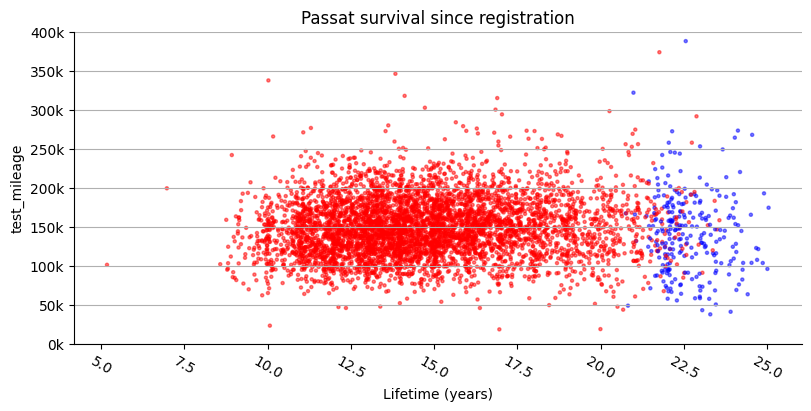

In [25]:
from simpler_mpl import set_common_mpl_styles, set_commas
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True)

passats_df.dropna().plot.scatter(
    figsize=(8, 4),
    x="lifetime",
    y="test_mileage",
    marker=".",
    alpha=0.5,
    # s=0.5,
    c="surviving_colour",
    ax=ax
)
#ax.set_xlim(5, 26)
ax.set_ylim(0, 400000)
#ax.plot(result["test_date"], result["passed"])  # , marker='o')
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x/1000):,}k")
plt.xticks(rotation=-30)
set_common_mpl_styles(
    ax, title="Passat survival since registration", ymin=0, xlabel="Lifetime (years)" #ylabel="Passing Tests per Week"
)


(0.0, 400000.0)

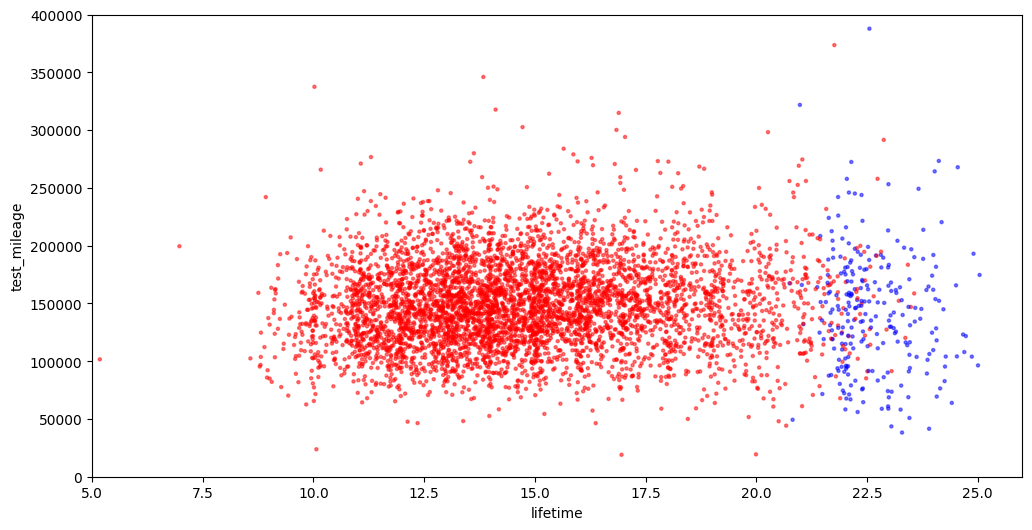

In [26]:
ax = passats_df.dropna().plot.scatter(
    figsize=(12, 6),
    x="lifetime",
    y="test_mileage",
    marker=".",
    alpha=0.5,
    # s=0.5,
    c="surviving_colour",
)
ax.set_xlim(5, 26)
ax.set_ylim(0, 400000)

In [27]:
passats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5195 entries, 268902 to 1499910714
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   make               5195 non-null   string        
 1   model              5195 non-null   string        
 2   fuel_type          5195 non-null   string        
 3   cylinder_capacity  5195 non-null   int64[pyarrow]
 4   first_use_date     5195 non-null   datetime64[ns]
 5   test_date          5195 non-null   datetime64[ns]
 6   test_mileage       5195 non-null   int64[pyarrow]
 7   lifetime           5195 non-null   float64       
 8   surviving          5195 non-null   bool          
 9   surviving_colour   5195 non-null   object        
 10  fuel_colour        5195 non-null   object        
 11  year               5195 non-null   int32         
dtypes: bool(1), datetime64[ns](2), float64(1), int32(1), int64[pyarrow](2), object(2), string(3)
memory usage: 505.4

Text(0.5, 1.0, 'Passat Survival')

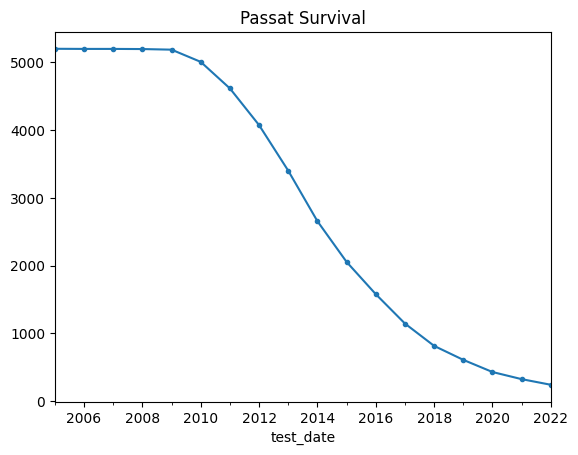

In [28]:
ax = (
    passats_df.resample(on="test_date", rule="1Y")
    .model.count()
    .loc[::-1]
    .cumsum()[::-1]
    .plot(marker=".")
)
ax.set_title("Passat Survival")

(0.0, 300000.0)

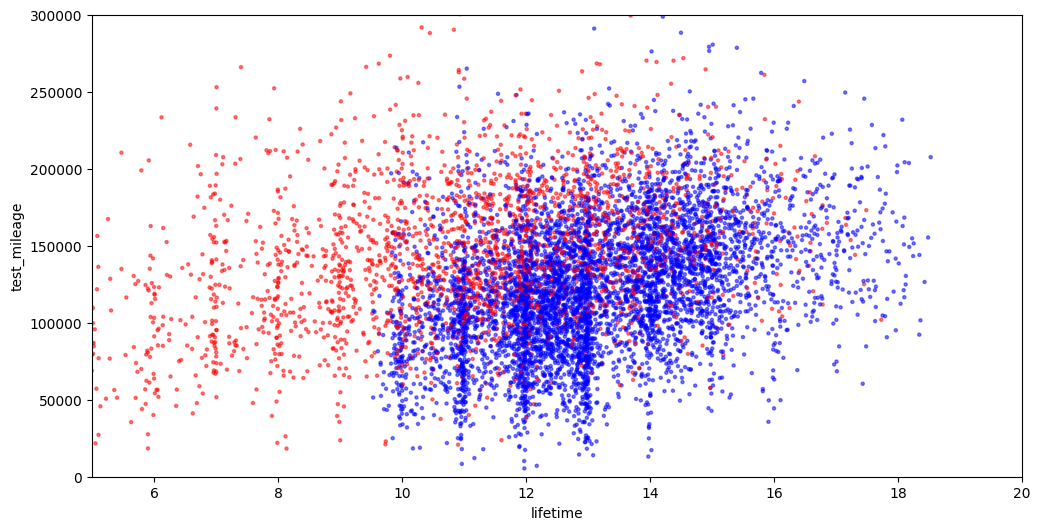

In [29]:
ax = v50s_df.dropna().plot.scatter(
    figsize=(12, 6),
    x="lifetime",
    y="test_mileage",
    marker=".",
    alpha=0.5,
    # s=0.5,
    c="surviving_colour",
)
ax.set_xlim(5, 20)
ax.set_ylim(0, 300000)

In [30]:
pd.concat([passats_df, v50s_df]).groupby(["make", "surviving"]).model.count()

make        surviving
VOLKSWAGEN  False        4951
            True          244
VOLVO       False        2403
            True         5634
Name: model, dtype: int64